In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
os.chdir('..')
from utils.utils import load_ckpt, AverageMeter, to_scalar
%matplotlib notebook
%matplotlib inline

## Dataset Preparation

### Dataset COnfigurations

In [2]:
data_root = "raw_data"
txt = "values_FAB.txt"
input_size = 2
output_size = 2
portion_train = 0.7
portion_val = 0.15
batch_size = 16
train_split = 'data_splits/' + txt.split('.')[0] + '_train.txt'
test_split = 'data_splits/' + txt.split('.')[0] + '_test.txt'
val_split = 'data_splits/' + txt.split('.')[0] + '_val.txt'


### Make Dataset

In [3]:

def make_dataset(data_root, txt, input_size, output_size, portion_train, portion_val):
    num_input = input_size
    num_output = output_size
    
    with open(train_split, 'r') as tr, open(test_split, 'r') as te, open(val_split, 'r') as val:
        strlines = tr.readlines()
        stelines = te.readlines()
        vallines = val.readlines()
 
    target_train = []
    target_test = []
    target_val = []
    input_train = []
    input_test = []
    input_val = []
 
    for line in strlines:
        line = eval(line.strip())
        line =  list(map(float, line))
        input_train.append(line[:num_input])
        target_train.append(line[num_input:(num_input + num_output)])
    for line in stelines:
        line = eval(line.strip())
        line =  list(map(float, line))
        input_test.append(line[:num_input])
        target_test.append(line[num_input:(num_input + num_output)])
    for line in vallines:
        line = eval(line.strip())
        line =  list(map(float, line))
        input_val.append(line[:num_input])
        target_val.append(line[num_input:(num_input + num_output)])

    target_train = np.array(target_train).astype(np.float32)
    input_train = np.array(input_train).astype(np.float32)
 
    target_test = np.array(target_test).astype(np.float32)
    input_test = np.array(input_test).astype(np.float32)
 
    target_val = np.array(target_val).astype(np.float32)
    input_val = np.array(input_val).astype(np.float32)

    target_scaler = StandardScaler()
    target_train = torch.from_numpy(target_scaler.fit_transform(target_train).astype(np.float32))
    target_test = torch.from_numpy(target_scaler.transform(target_test).astype(np.float32))
    target_val = torch.from_numpy(target_scaler.transform(target_val).astype(np.float32))

    input_scaler = StandardScaler()
    input_train = torch.from_numpy(input_scaler.fit_transform(input_train).astype(np.float32))
    input_test = torch.from_numpy(input_scaler.transform(input_test).astype(np.float32))
    input_val = torch.from_numpy(input_scaler.transform(input_val).astype(np.float32))

    return BlastWall(input_train, target_train), BlastWall(input_val, target_val), BlastWall(input_test, target_test)



class BlastWall(Dataset):

    def __init__(self, input, target):
        self.input = input
        self.target = target


    def __len__(self):
        return self.input.size()[0]

    def __getitem__(self, idx):
        return self.input[idx], self.target[idx]

# Build dataset and dataloader
    
    
train_set, val_set, test_set = make_dataset(data_root, txt, input_size, \
                                   output_size, portion_train, portion_val)
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    drop_last=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    num_workers=2,
    drop_last=False)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=2,
    drop_last=False)

## Model

### Model Configurations

In [4]:
model_kwargs = {'input_size':2,'num_h': 1,'hidden_size':[20], 'output_size': 2}
lr = 0.01

### Build Model

In [5]:
class RegressionModel(nn.Module):

    def __init__(self, input_size, num_h, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        assert len(hidden_size) == num_h
        # Add input_size and output_size to the list
        hidden_size.insert(0, input_size)
        hidden_size.append(output_size)
        modules = []
        # Append model elements sequentially
        for l in range(len(hidden_size)-1):
            modules.append(nn.Linear(hidden_size[l], hidden_size[l+1]))
            if l == len(hidden_size)-2: break
            modules.append(nn.ReLU())

        self.model = nn.Sequential(*modules)
        self.model.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, X):

        out = self.model(X)

        return out
    
model = RegressionModel(**model_kwargs)
optimizer = optim.Adam(model.parameters(), lr=lr)
modules_optims = [model, optimizer]

<ipython-input-5-6377e2f1639d>:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


## Inference

In [6]:
from utils.utils import may_set_mode
from sklearn.metrics import r2_score
# Loss function
criterion = nn.MSELoss()
# Weight Path
exp_dir  = "exp/values_FAB/run1"
best_epoch = 59

e, s = load_ckpt(modules_optims, os.path.join(exp_dir, 'model', 'ckpt_epoch{}.pth'.format(best_epoch)))
may_set_mode(modules_optims, 'eval')



# Infe on test set
tepred_list = []
tetarget_list = []
teloss_meter = AverageMeter()
for i, (sample_test, target_test) in enumerate(test_loader):
    with torch.no_grad():
        output = model(sample_test)
    teloss = criterion(output, target_test)
    teloss_meter.update(to_scalar(teloss))
    tepred_list.extend(output.tolist())
    tetarget_list.extend(target_test.tolist())

# Infer on val set
valpred_list = []
valtarget_list = []
valloss_meter = AverageMeter()
for i, (sample_test, target_test) in enumerate(val_loader):
    with torch.no_grad():
        output = model(sample_test)
    valloss = criterion(output, target_test)
    valloss_meter.update(to_scalar(valloss))
    valpred_list.extend(output.tolist())
    valtarget_list.extend(target_test.tolist())
    
# Infer on train set

trpred_list = []
trtarget_list = []
trloss_meter = AverageMeter()
for i, (sample_test, target_test) in enumerate(train_loader):
    with torch.no_grad():
        output = model(sample_test)
    trloss = criterion(output, target_test)
    trloss_meter.update(to_scalar(trloss))
    trpred_list.extend(output.tolist())
    trtarget_list.extend(target_test.tolist())

# Inferr on all
allpred_list = trpred_list + tepred_list + valpred_list
alltarget_list = trtarget_list + tetarget_list + valtarget_list



Resume from ckpt exp/values_FAB/run1/model/ckpt_epoch59.pth, 
epoch: 59, scores: 0


## Visualization

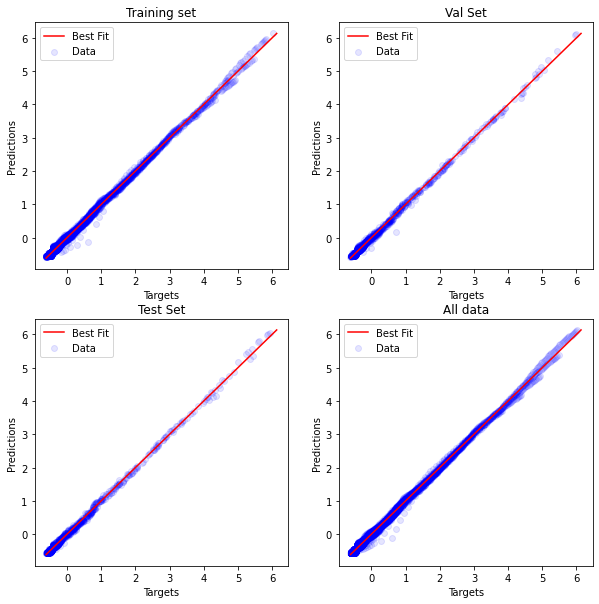

In [14]:
var_index = 0
fig, axs = plt.subplots(2, 2, figsize=(10,10))
x = np.linspace(min(min([d[var_index] for d in allpred_list]), min([d[var_index] for d in alltarget_list])), 
                max(max([d[var_index] for d in allpred_list]), max([d[var_index] for d in alltarget_list])), 
                1000)

axs[0,0].title.set_text('Training set')
axs[0,0].plot(x,x,'r',label="Best Fit")
axs[0,0].scatter(x = [d[var_index] for d in trpred_list], y = [d[var_index] for d in trtarget_list],
                 c='blue', marker='o', alpha=0.1, label="Data")
axs[0,0].set_xlabel('Targets')
axs[0,0].set_ylabel('Predictions')
axs[0,0].legend(loc='upper left')

axs[0,1].title.set_text('Val Set')
axs[0,1].plot(x,x,'r',label="Best Fit")
axs[0,1].scatter(x = [d[var_index] for d in valpred_list], y = [d[var_index] for d in valtarget_list],
                 c='blue', marker='o', alpha=0.1, label="Data")
axs[0,1].set_xlabel('Targets')
axs[0,1].set_ylabel('Predictions')
axs[0,1].legend(loc='upper left')

axs[1,0].title.set_text('Test Set')
axs[1,0].plot(x,x,'r',label="Best Fit")
axs[1,0].scatter(x = [d[var_index] for d in tepred_list], y = [d[var_index] for d in tetarget_list],
                 c='blue', marker='o', alpha=0.1, label="Data")
axs[1,0].set_xlabel('Targets')
axs[1,0].set_ylabel('Predictions')
axs[1,0].legend(loc='upper left')

axs[1,1].title.set_text('All data')
axs[1,1].plot(x,x,'r',label="Best Fit")
axs[1,1].scatter(x = [d[var_index] for d in allpred_list], y = [d[var_index] for d in alltarget_list],
                 c='blue', marker='o', alpha=0.1,label="Data")
axs[1,1].set_xlabel('Targets')
axs[1,1].set_ylabel('Predictions')
axs[1,1].legend(loc='upper left')